# AI in Medicine Practical

# **Exercise: Dimensionality Reduction and Reconstruction for Anomaly Detection**

---
For questions contact: cosmin.bercea@tum.de
---


## **Overview**

This exercise focuses on **dimensionality reduction and reconstruction** for detecting anomalies in brain MRI images. Specifically, you will use **mid-axial brain MRI (T1-weighted)** scans to detect and analyze stroke anomalies using techniques like **Principal Component Analysis (PCA)** and **Variational Autoencoders (VAE)**.

---

### **Goals**

1. Implement dimensionality reduction techniques for image reconstruction.
2. Use these methods to detect anomalies in brain MRIs.
3. Compare the effectiveness of PCA and VAE for anomaly detection.
4. Visualize and interpret the results to understand their behavior.

---

### **Structure**

1. **Coding Exercises**: Tasks requiring implementation or completion of code are marked as **(C1, C2, ...)**.
2. **Conceptual Questions**: Analytical and interpretative questions are marked as **(Q1, Q2, ...)**.

---

## **Tasks**

### **Dimensionality Reduction and Anomaly Detection with PCAs and VAEs**

1. **PCA for Reconstruction** (30 points)
2. **PCA for Anomaly Detection** (30 points)
3. **Improved PCA for Anomaly Detection** (10 points)
4. **Anomaly Detection with VAEs** (30 points)

---

## **Dataset Description**

The dataset consists of:
- **Brain MRI Images**: Mid-axial slices of T1-weighted MRIs from healthy and stroke cases.
- **Stroke Masks**: Binary masks indicating stroke regions.

Each image is preprocessed to:
- Have a size of **128x128 pixels**.
- Be normalized to the range **[0, 1]**.
- Correspond with a mask showing stroke regions.

---

## **Instructions**

2. **Step-by-Step Implementation**:
   - Follow the notebook's structure to complete the coding exercises and answer the questions.

---

### **Good Luck! 🚀**


---
### SETUP

Install packages

In [1]:
## DO THIS IF ON GOOGLE COLAB
!pip install pytorch-lightning

   ---------------------------------------- 0.0/849.5 kB ? eta -:--:--
   --------------------------------------- 849.5/849.5 kB 18.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/983.2 kB ? eta -:--:--
   --------------------------------------- 983.2/983.2 kB 15.7 MB/s eta 0:00:00

   ---------------------------------------- 0/3 [lightning-utilities]
   ------------- -------------------------- 1/3 [torchmetrics]
   ------------- -------------------------- 1/3 [torchmetrics]
   ------------- -------------------------- 1/3 [torchmetrics]
   ------------- -------------------------- 1/3 [torchmetrics]
   ------------- -------------------------- 1/3 [torchmetrics]
   ------------- -------------------------- 1/3 [torchmetrics]
   ------------- -------------------------- 1/3 [torchmetrics]
   ------------- -------------------------- 1/3 [torchmetrics]
   ------------- -------------------------- 1/3 [torchmetrics]
   ------------- -------------------------- 1/3 [torchmetric

In [4]:

# Step 1: Setup
# Import Required Libraries
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


# Check GPU availability for Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---
### Download the data

In [10]:
# Step 2: Dataset Setup
# Download the dataset
import urllib.request
import zipfile
import os

url = "https://syncandshare.lrz.de/dl/fi99En3eCa6MtmBYAHJ4EQ/Atlas_train_.zip"
save_path = "dataset.zip"

# 下载文件
urllib.request.urlretrieve(url, save_path)
print("downloaded！")

# 解压文件
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall("./data")
print("finished！")


downloaded！
finished！


In [7]:
 #Preprocessing: Load Images and Corresponding Masks
class BrainDataset(Dataset):
    def __init__(self, data_dir):
        """
        Dataset class for loading brain images and corresponding masks.

        Args:
        - data_dir (str): Path to the dataset directory containing images and masks.
        """
        self.data_dir = data_dir
        self.image_paths = [
            os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if "mask" not in fname and fname.endswith(".png")
        ]
        self.mask_paths = [
            img_path.replace(".png", "_mask.png") for img_path in self.image_paths
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Loads an image-mask pair at the given index.

        Args:
        - idx (int): Index of the image-mask pair.

        Returns:
        - img (torch.Tensor): Image tensor (H, W).
        - mask (torch.Tensor): Corresponding mask tensor (H, W).
        """
        # Load image and mask
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        img = imread(img_path, as_gray=True).astype(np.float32)  # Load grayscale image
        mask = imread(mask_path, as_gray=True).astype(np.float32)  # Load grayscale mask

        # Normalize image to [0, 1]
        img /= 255.0
        mask /= 255.0

        # Convert to PyTorch tensors
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return img, mask

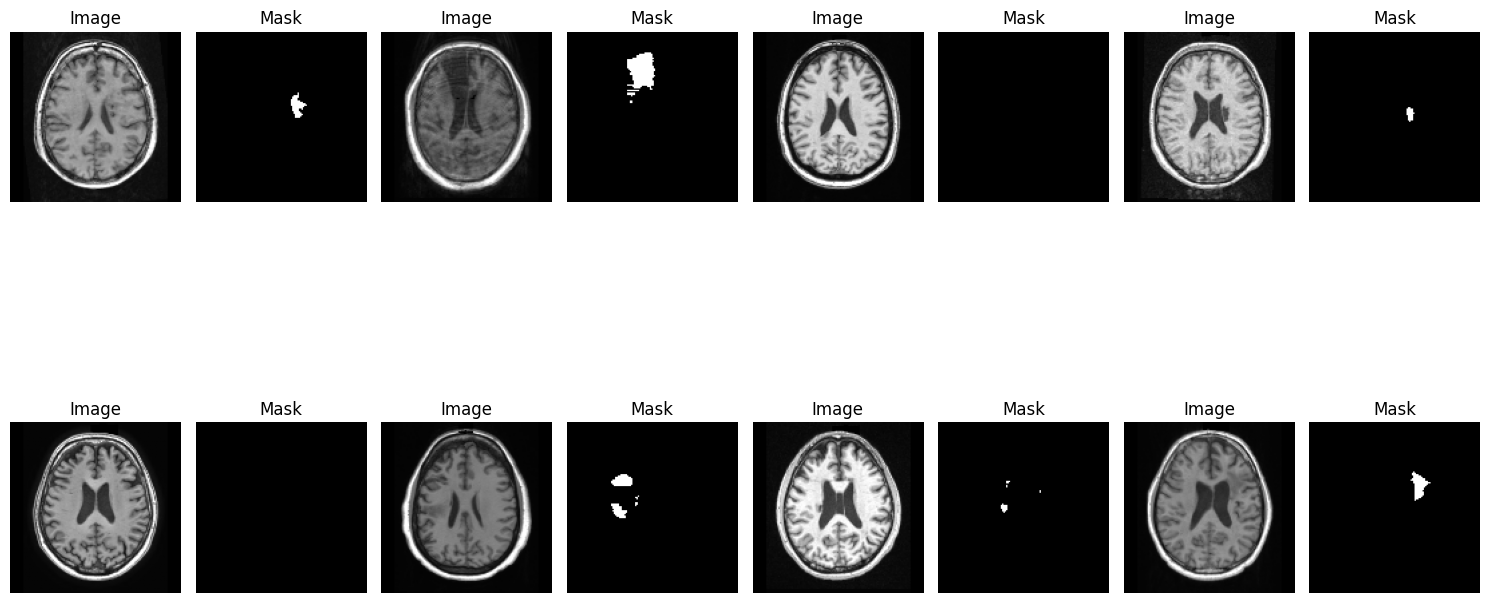

In [8]:
# Usage Example:
data_dir = "./data/Atlas_train_"  # Path to the dataset directory
dataset = BrainDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Visualize a sample batch
def show_image_mask_pairs(batch, ncols=4):
    """
    Visualizes image-mask pairs from a batch.

    Args:
    - batch (tuple): A tuple containing image tensors and mask tensors.
    - ncols (int): Number of columns in the visualization grid.
    """
    images, masks = batch
    nrows = (len(images) + ncols - 1) // ncols

    plt.figure(figsize=(15, 5 * nrows))
    for idx in range(len(images)):
        plt.subplot(nrows, ncols * 2, idx * 2 + 1)
        plt.imshow(images[idx].squeeze().cpu().numpy(), cmap="gray")
        plt.title("Image")
        plt.axis("off")

        plt.subplot(nrows, ncols * 2, idx * 2 + 2)
        plt.imshow(masks[idx].squeeze().cpu().numpy(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize a sample batch from the dataloader
sample_batch = next(iter(dataloader))
show_image_mask_pairs(sample_batch)

Healthy Train Size: 180, Healthy Test Size: 32
Stroke Train Size: 411, Stroke Test Size: 32


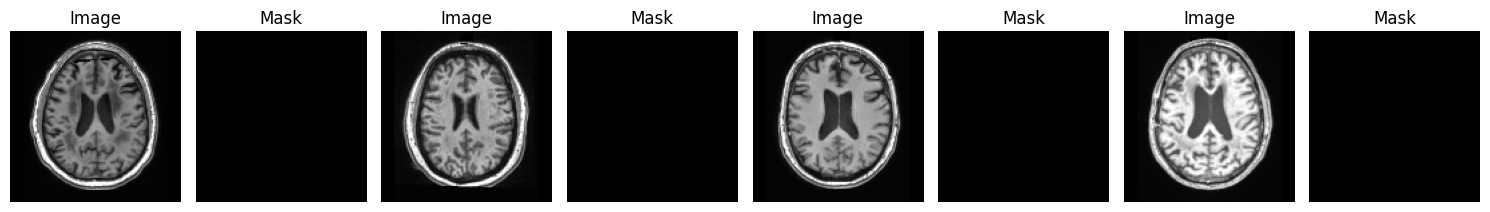

In [11]:
def split_healthy_and_stroke(dataset):
    """
    Splits the dataset into healthy and stroke cases based on the masks.

    Args:
    - dataset (Dataset): An instance of the BrainDataset.

    Returns:
    - healthy_indices (list): List of indices corresponding to healthy cases.
    - stroke_indices (list): List of indices corresponding to stroke cases.
    """
    healthy_indices = []
    stroke_indices = []

    for idx in range(len(dataset)):
        _, mask = dataset[idx]  # Load the mask
        if torch.any(mask > 0):  # Check if any pixel in the mask is highlighted
            stroke_indices.append(idx)
        else:
            healthy_indices.append(idx)

    return healthy_indices, stroke_indices

# Example Usage:
healthy_total_indices, stroke_total_indices = split_healthy_and_stroke(dataset)
# Split indices for healthy dataset
healthy_train_indices = healthy_total_indices[:-32]  # All but the last 32
healthy_test_indices = healthy_total_indices[-32:]  # Last 32

# Split indices for stroke dataset
stroke_train_indices = stroke_total_indices[:-32]  # All but the last 32
stroke_test_indices = stroke_total_indices[-32:]  # Last 32

# Create training and testing subsets
healthy_train_dataset = torch.utils.data.Subset(dataset, healthy_train_indices)
healthy_test_dataset = torch.utils.data.Subset(dataset, healthy_test_indices)

stroke_train_dataset = torch.utils.data.Subset(dataset, stroke_train_indices)
stroke_test_dataset = torch.utils.data.Subset(dataset, stroke_test_indices)

# Print dataset sizes
print(f"Healthy Train Size: {len(healthy_train_dataset)}, Healthy Test Size: {len(healthy_test_dataset)}")
print(f"Stroke Train Size: {len(stroke_train_dataset)}, Stroke Test Size: {len(stroke_test_dataset)}")

# Visualize samples from the training set
sample_batch = next(iter(DataLoader(healthy_test_dataset, batch_size=4, shuffle=True)))
show_image_mask_pairs(sample_batch)

## **Step 1: Dimensionality Reduction with PCA**

In this part of the exercise, you will prepare the MRI dataset for **Principal Component Analysis (PCA)**. PCA requires input data to be in a vectorized form, so we need to flatten the images into 1D vectors. Each image is originally in a **128x128** grid, which will be flattened into a vector of size **16,384 (128x128)**.

You will also apply PCA to both the healthy and stroke datasets to reduce the dimensionality of the data. For this part, we will:
1. Flatten the images in the dataset for PCA processing.
2. Apply PCA to reduce the dimensionality to the specified number of components (**`pca_components`**).
3. Visualize the first two principal components to analyze the latent space.
4. Identify what the main drivers for the variance in these two componens are 

---

### **Tasks**

- **(C1)**: Complete the function `prepare_pca_data` to flatten images in a dataset. 
- **(C2)**: Complete the PCA transformation process for both the healthy and stroke datasets.
- **(Q1)**: Visualize the first two principal components using the provided script (plot_interactive_latent_space) and describe the patterns you observe.
    
- **(C3)**: Complete the function min/max to visuaalize the outlier points in both PC1 and PC2. 
- **(Q2)**: Visualize the outliers for both components (PC1/PC2) for both healthy/stroke samples. What do you observe? What could be the main attribute for variance along these dimensions?

---

### **Instructions**

1. Fill in the missing code marked as `# TODO` to complete the tasks.
2. Execute the cell to prepare the data for PCA and apply dimensionality reduction.
3. Use the provided visualization function (`plot_interactive_latent_space`) to explore the latent space of healthy and stroke data.
4. Describe the separation (or overlap) between healthy and stroke data in the latent space.
5. Fill in the missing code and execute the cells to visuzlize the outliers for the PC1 and PC2 dimension.
6. Describe the main drivers for variance based on the visualizations. 

---

In [19]:
# Function to plot interactive latent space
def plot_interactive_latent_space(healthy_latent, stroke_latent):
    """
    Interactive PCA latent space plot using Plotly.

    Args:
    - healthy_latent (numpy.ndarray): Latent space of healthy data.
    - stroke_latent (numpy.ndarray): Latent space of stroke data.
    """
    # Combine healthy and stroke latent spaces into a DataFrame
    latent_data = np.vstack([healthy_latent, stroke_latent])
    labels = ["Healthy"] * len(healthy_latent) + ["Stroke"] * len(stroke_latent)
    df = pd.DataFrame(latent_data, columns=["PC1", "PC2"])
    df["Label"] = labels

    # Plotly scatter plot
    fig = px.scatter(
        df,
        x="PC1",
        y="PC2",
        color="Label",
        title="Interactive PCA Latent Space: Healthy vs Stroke",
        labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"},
        color_discrete_map={"Healthy": "blue", "Stroke": "red"},
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(title_font_size=20, legend_title_font_size=14)
    fig.show()

In [22]:
# Step 1: Prepare data for PCA
# Flatten images into vectors for PCA
pca_components = 2
def prepare_pca_data(dataset):
    """
    将 Dataset / Subset 中的图像拉平成 (N, 128*128) 的 numpy 数组，
    只使用图像，不使用 mask。
    """
    data_list = []
    for i in range(len(dataset)):
        img, _ = dataset[i]          # img: torch.Size([1, 128, 128])
        img_np = img.squeeze(0).numpy()   # -> (128, 128)
        data_list.append(img_np.reshape(-1))  # 展平成一维

    data_array = np.stack(data_list, axis=0)  # (N, 16384)
    return data_array 


healthy_train_data = prepare_pca_data(healthy_train_dataset)
stroke_train_data = prepare_pca_data(stroke_train_dataset)
healthy_test_data = prepare_pca_data(healthy_test_dataset)
stroke_test_data = prepare_pca_data(stroke_test_dataset)

# Step 2: Apply PCA
healthy_train_latent = pca_healthy.fit_transform(healthy_train_data)
healthy_test_latent  = pca_healthy.transform(healthy_test_data)

# Interactive Latent Space Visualization
plot_interactive_latent_space(healthy_train_latent, stroke_train_latent)

In [14]:
def visualize_variance_pca(
    data_train, latent_train, data_test, latent_test, pca, pc_index, dataset_label="Healthy", title_suffix="Variance Along PC"
):
    """
    Visualizes the images corresponding to the minimum and maximum values along a specific principal component
    for both train and test datasets in a compact grid with a separating line for clarity.
    """

    # Identify min and max indices for train data
    train_min_index = np.argmin(latent_train[:, pc_index])
    train_max_index = np.argmax(latent_train[:, pc_index])

    # Identify min and max indices for test data
    test_min_index = np.argmin(latent_test[:, pc_index])
    test_max_index = np.argmax(latent_test[:, pc_index])

    # Retrieve the corresponding images
    train_original_samples = data_train[[train_min_index, train_max_index]].reshape(-1, 128, 128)
    train_reconstructed_samples = pca.inverse_transform(latent_train[[train_min_index, train_max_index]]).reshape(-1, 128, 128)

    test_original_samples = data_test[[test_min_index, test_max_index]].reshape(-1, 128, 128)
    test_reconstructed_samples = pca.inverse_transform(latent_test[[test_min_index, test_max_index]]).reshape(-1, 128, 128)

    # Create figure and grid
    fig = plt.figure(figsize=(12, 8))
    grid = fig.add_gridspec(nrows=2, ncols=2, hspace=0.1, wspace=0.4)

    # Add grouped title
    fig.suptitle(f"{dataset_label} {title_suffix} (PC{pc_index + 1})", fontsize=16, y=0.98)

    # Train Row
    train_ax1 = fig.add_subplot(grid[0, 0])
    train_ax1.imshow(np.hstack([train_original_samples[0], train_reconstructed_samples[0]]), cmap="gray")
    train_ax1.set_title("Train Min Variance", fontsize=12)
    train_ax1.axis("off")

    train_ax2 = fig.add_subplot(grid[0, 1])
    train_ax2.imshow(np.hstack([train_original_samples[1], train_reconstructed_samples[1]]), cmap="gray")
    train_ax2.set_title("Train Max Variance", fontsize=12)
    train_ax2.axis("off")

    # Test Row
    test_ax1 = fig.add_subplot(grid[1, 0])
    test_ax1.imshow(np.hstack([test_original_samples[0], test_reconstructed_samples[0]]), cmap="gray")
    test_ax1.set_title("Test Min Variance", fontsize=12)
    test_ax1.axis("off")

    test_ax2 = fig.add_subplot(grid[1, 1])
    test_ax2.imshow(np.hstack([test_original_samples[1], test_reconstructed_samples[1]]), cmap="gray")
    test_ax2.set_title("Test Max Variance", fontsize=12)
    test_ax2.axis("off")

    # Add separating line below the entire Test row
    line_ax = fig.add_subplot(grid.new_subplotspec((1, 0), colspan=2))
    line_ax.axhline(y=0, xmin=0, xmax=1, color="gray", linestyle="--", linewidth=1.5)
    line_ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [15]:
# Apply PCA（用于后面 variance / outlier 的可视化）
pca_components = 2
pca_healthy = PCA(n_components=pca_components)
pca_stroke = PCA(n_components=pca_components)

# —— Healthy 数据 —— #
# 用 healthy train 拟合 PCA，并得到 train / test 的 latent 表示
healthy_train_latent = pca_healthy.fit_transform(healthy_train_data)
healthy_test_latent  = pca_healthy.transform(healthy_test_data)

# —— Stroke 数据 —— #
stroke_train_latent = pca_stroke.fit_transform(stroke_train_data)
stroke_test_latent  = pca_stroke.transform(stroke_test_data)


C:\Users\Jianfeng Yue\AppData\Local\Temp\ipykernel_10332\1709318958.py:58: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



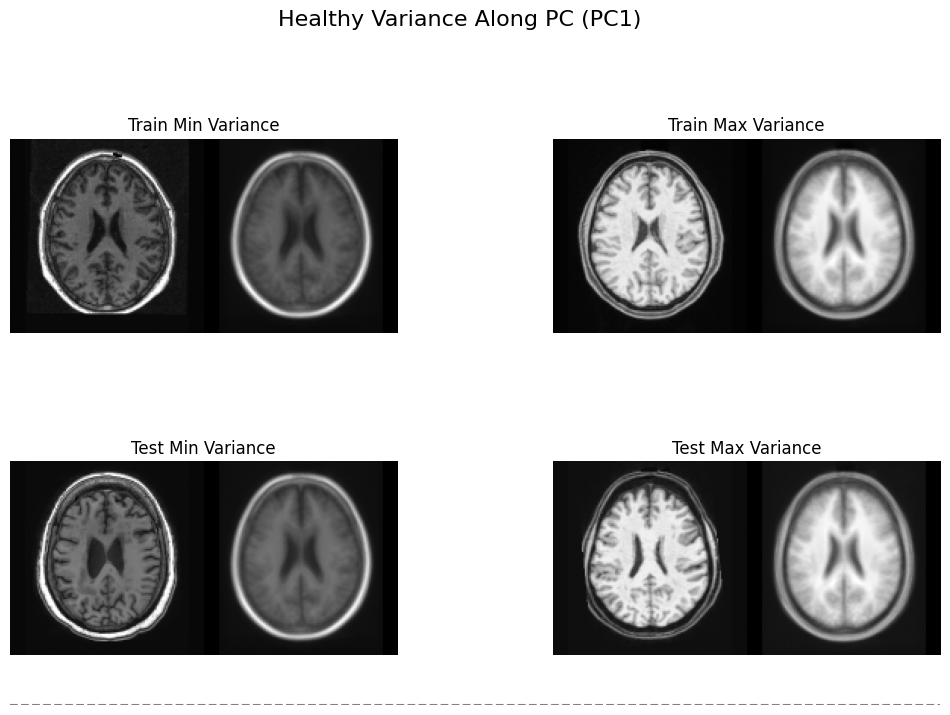

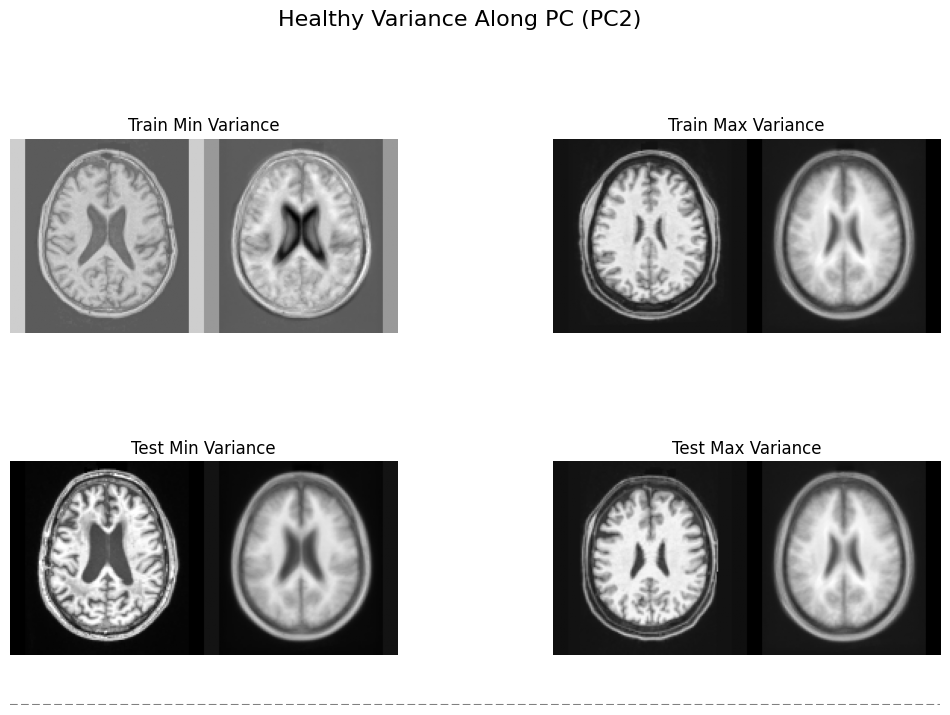

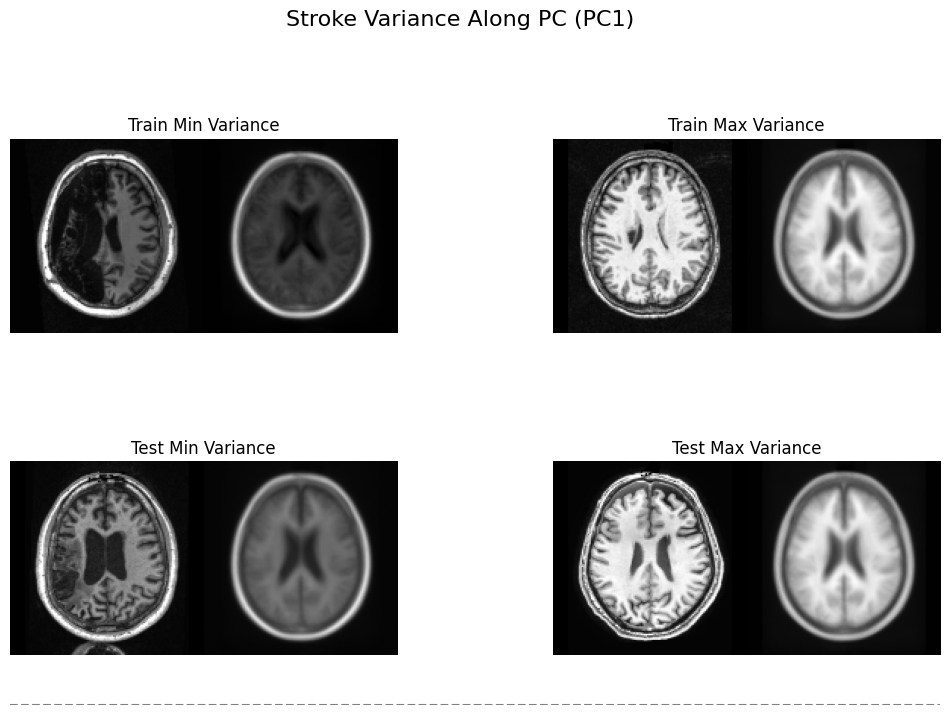

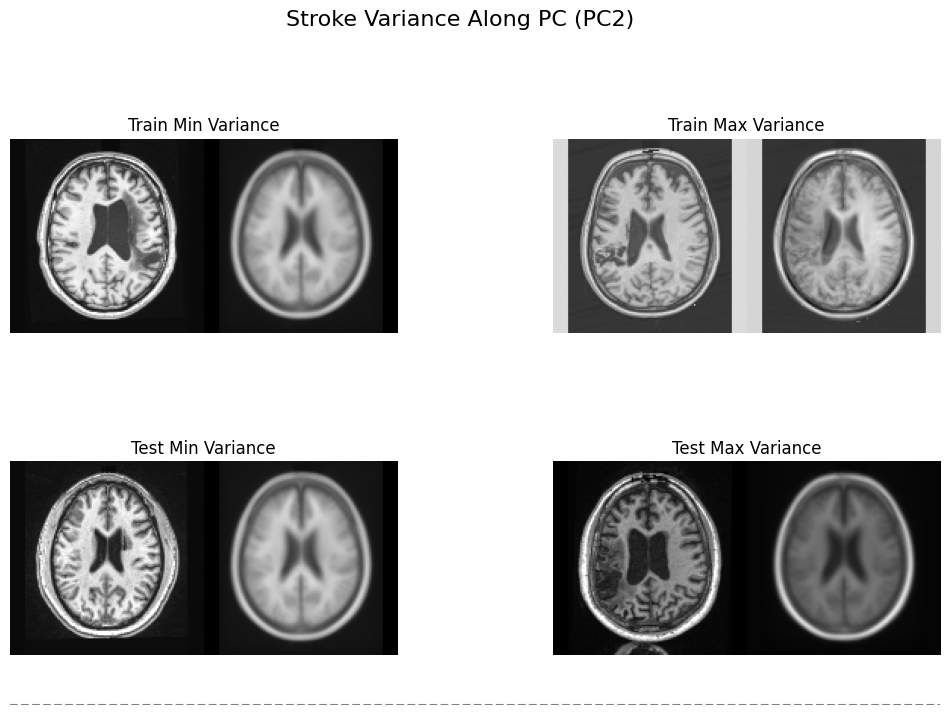

In [16]:
# Visualize for Healthy Dataset
visualize_variance_pca(
    healthy_train_data, healthy_train_latent, healthy_test_data, healthy_test_latent,
    pca_healthy, pc_index=0, dataset_label="Healthy", title_suffix="Variance Along PC"
)
visualize_variance_pca(
    healthy_train_data, healthy_train_latent, healthy_test_data, healthy_test_latent,
    pca_healthy, pc_index=1, dataset_label="Healthy", title_suffix="Variance Along PC"
)

# Visualize for Stroke Dataset
visualize_variance_pca(
    stroke_train_data, stroke_train_latent, stroke_test_data, stroke_test_latent,
    pca_stroke, pc_index=0, dataset_label="Stroke", title_suffix="Variance Along PC"
)
visualize_variance_pca(
    stroke_train_data, stroke_train_latent, stroke_test_data, stroke_test_latent,
    pca_stroke, pc_index=1, dataset_label="Stroke", title_suffix="Variance Along PC"
)


## **Step 2: Reconstruction and Anomaly Detection**

In this step, you will explore how PCA can be used not only for dimensionality reduction but also for reconstructing images and detecting anomalies. By learning a low-dimensional representation from training data and reconstructing test data, PCA can highlight differences (**anomalies**) between the reconstructed images and the original ones.

---

### **Objective**

1. Train a PCA model using **training data**.
2. Reconstruct images from the **test dataset** using the learned PCA basis.
3. Compute **anomaly maps** as the absolute pixel-wise difference between the input and the reconstructed images.
4. Visualize and interpret the reconstructions and anomaly maps.

---

### **Tasks**

- **(C4)**: Implement the function `compute_reconstruction_and_anomaly` to perform PCA-based reconstruction and compute anomaly maps.
- **(Q3)**: Use this function to analyze a sample of test images and their anomaly maps for different number of principal components. What do you observe? 
- **(C5)**: Fill the function 'analyze_components_vs_error' to determine the optimal number of principal components that maximizes the difference between healthy and stroke errors. 
- **(Q4)**: Plot the error curves for healthy and stroke errors using the provided script 'plot_errors_and_gap'. What do you observe?
- **(Q5)**: Generate the distribution plot using the identified optimal number of principal components using the function 'plot_error_distributions_with_overlap'. What do you observe? What is the expected, ideal scenario? 
- **(C6)**: Implement a metric to measure the overlap between these two distributions (healthy vs. stroke reconstruction errors to add it to the plot) in the 'compute_overlap' function. What is the ideal value of the metric for perfect anomaly detection performance?


In [ ]:
def compute_reconstruction_and_anomaly(train_data, test_data, n_components):
    """
    Computes PCA reconstruction and anomaly maps using a PCA model trained on the train data.

    Args:
    - train_data (numpy.ndarray): Flattened training dataset (e.g., stroke images).
    - test_data (numpy.ndarray): Flattened test dataset to reconstruct using the PCA model.
    - n_components (int): Number of PCA components to use.

    Returns:
    - reconstructed (numpy.ndarray): Reconstructed test images based on the PCA model.
    - anomaly_maps (numpy.ndarray): Difference between original and reconstructed test images.
    """
    #TODO: Fit PCA model on training data
    pca = 

    # Project test data onto the train PCA basis
    latent = #TODO: embed latent 
    reconstructed = #TODO: inverse from latent 

    # Compute anomaly maps (absolute difference)
    anomaly_maps = np.abs(test_data - reconstructed)

    return reconstructed, anomaly_maps


In [ ]:
def visualize_reconstructions_with_gt(stroke_train_data,
    data, masks, n_components_list, example_index=0, title="PCA Reconstruction and Anomaly Maps with GT"
):
    """
    Visualizes a single example for different numbers of PCA components, including the ground truth mask.

    Args:
    - data (numpy.ndarray): Flattened dataset (e.g., stroke images).
    - masks (numpy.ndarray): Flattened ground truth masks corresponding to the dataset.
    - n_components_list (list): List of numbers of PCA components to use.
    - example_index (int): Index of the example to visualize.
    - title (str): Title for the visualization.
    """
    original_sample = data[example_index].reshape(128, 128)  # Assuming 128x128 images
    mask_sample = masks[example_index].reshape(128, 128)  # Corresponding ground truth mask

    # Prepare plots
    fig, axes = plt.subplots(3, len(n_components_list), figsize=(20, 10))

    for i, n_components in enumerate(n_components_list):
        # Compute reconstruction and anomaly map
        reconstructed, anomaly_maps = compute_reconstruction_and_anomaly(stroke_train_data, data, n_components)
        reconstructed_sample = reconstructed[example_index].reshape(128, 128)
        anomaly_sample = anomaly_maps[example_index].reshape(128, 128)

        # Original Image (First Row)
        if i == 0:
            axes[0, i].imshow(original_sample, cmap="gray")
            axes[0, i].set_title("Input")
        elif i == 1:
            axes[0, i].imshow(mask_sample, cmap='magma', vmin=0,vmax=1)
            axes[0, i].set_title("Ground Truth (Mask)")
        axes[0, i].axis("off")

        # Reconstructed Image (Third Row)
        axes[1, i].imshow(reconstructed_sample, cmap="gray")
        axes[1, i].set_title(f"Reconstructed\n({n_components} PCs)")
        axes[1, i].axis("off")

        # Anomaly Map (Fourth Row)
        axes[2, i].imshow(anomaly_sample, cmap="magma", vmin=0, vmax=1)
        axes[2, i].set_title("Anomaly Map")
        axes[2, i].axis("off")

    # Set overall title
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# List of n_components to analyze
n_components_list = [2, 20, 50, 100, 150]

def prepare_masks_data(dataset):
    flattened_images = []
    for _, mask in dataset:  # Only use masks, not images
        flattened_images.append(mask.view(-1).numpy())  # Flatten the image
    return np.array(flattened_images)
# Visualize for a single example from the stroke dataset
stroke_test_masks = prepare_masks_data(stroke_test_dataset)
visualize_reconstructions_with_gt(
    stroke_train_data,
    stroke_test_data,
    stroke_test_masks,
    n_components_list,
    example_index=4,
    title="Stroke Dataset: PCA Reconstruction, Anomaly Maps, and Ground Truth"
)


In [ ]:
import seaborn as sns

In [ ]:
def analyze_components_vs_error(data_train_healthy, data_test_healthy, data_train_stroke, data_test_stroke, max_components, step=10):
    """
    Analyze reconstruction errors with varying principal components for healthy and stroke data in steps.

    Args:
    - data_healthy (numpy.ndarray): Flattened healthy dataset.
    - data_stroke (numpy.ndarray): Flattened stroke dataset.
    - max_components (int): Maximum number of principal components.
    - step (int): Step size for n_components.

    Returns:
    - n_components_list (list): List of principal component numbers analyzed.
    - healthy_errors (list): Mean reconstruction errors for healthy data.
    - stroke_errors (list): Mean reconstruction errors for stroke data.
    - error_gaps (list): Differences between stroke and healthy reconstruction errors.
    - separation_components (int): Number of components with maximum error separation.
    """
    healthy_errors = []
    stroke_errors = []
    error_gaps = []
    n_components_list = list(range(step, max_components + 1, step))

    for n in n_components_list:
        # Fit PCA on healthy data
        _, healthy_error = compute_reconstruction_and_anomaly(data_train_healthy, data_test_healthy, n)
        _, stroke_error = compute_reconstruction_and_anomaly(data_train_stroke, data_test_stroke, n)
        healthy_errors.append(np.mean(healthy_error))
        stroke_errors.append(np.mean(stroke_error))
        error_gaps.append(#TODO: append error GAP)

    # Identify the number of components with maximum error separation
    separation_index = #TODO: find the position of the max error gap
    separation_components = n_components_list[separation_index]

    return n_components_list, healthy_errors, stroke_errors, error_gaps, separation_components

# Analyze for healthy and stroke data
max_components = 180
step = 10
n_components_list, healthy_errors, stroke_errors, error_gaps, separation_components = analyze_components_vs_error(
    healthy_train_data, healthy_test_data, stroke_train_data, stroke_test_data, max_components, step
)

In [ ]:
def plot_errors_and_gap(n_components_list, healthy_errors, stroke_errors, error_gaps, separation_components):
    """
    Creates a modern, integrated visualization using area and scatter plots,
    with the number of components highlighted above the max gap point.

    Args:
    - n_components_list (list): List of principal component numbers analyzed.
    - healthy_errors (list): Mean reconstruction errors for healthy data.
    - stroke_errors (list): Mean reconstruction errors for stroke data.
    - error_gaps (list): Differences between stroke and healthy reconstruction errors.
    - separation_components (int): Number of components with maximum error separation.
    """
    # Create a DataFrame for easier plotting
    data = pd.DataFrame({
        "Number of Components": n_components_list,
        "Healthy Errors": healthy_errors,
        "Stroke Errors": stroke_errors,
        "Error Gap": error_gaps
    })

    # Create the plot
    sns.set(style="whitegrid", context="talk")
    plt.figure(figsize=(14, 8))

    # Plot Healthy and Stroke Errors as area plots
    plt.fill_between(
        n_components_list, healthy_errors, stroke_errors,
        color="lightblue", alpha=0.3, label="Error Gap Area"
    )
    plt.scatter(n_components_list, healthy_errors, color="blue", label="Healthy Errors", s=80)
    plt.scatter(n_components_list, stroke_errors, color="red", label="Stroke Errors", s=80)

    # Highlight the maximum gap point
    max_gap_index = n_components_list.index(separation_components)
    plt.scatter(
        [separation_components], [error_gaps[max_gap_index]],
        color="purple", s=120, label=f"Max Gap at {separation_components} PCs", zorder=10
    )
    plt.text(
        separation_components, error_gaps[max_gap_index] + 0.005,
        f"{error_gaps[max_gap_index]:.5f}\n{separation_components} PCs",
        color="purple", fontsize=12, ha='center', va='bottom'
    )

    # Error Gap as a smooth line
    sns.lineplot(
        x=n_components_list, y=error_gaps, label="Error Gap (Stroke - Healthy)",
        color="purple", linestyle="--", linewidth=2
    )

    # Customizing the plot
    plt.title("Reconstruction Errors and Error Gap vs Number of Components", fontsize=18)
    plt.xlabel("Number of Components", fontsize=14)
    plt.ylabel("Error", fontsize=14)
    plt.legend(fontsize=12, title="Metrics")
    plt.grid(visible=True, which='major', linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot the integrated visualization
plot_errors_and_gap(n_components_list, healthy_errors, stroke_errors, error_gaps, separation_components)


In [ ]:
def compute_overlap(healthy_errors, stroke_errors):
    """
    Computes the Bhattacharyya coefficient, a measure of overlap between two distributions.

    Args:
    - healthy_errors (numpy.ndarray): Reconstruction errors for healthy data.
    - stroke_errors (numpy.ndarray): Reconstruction errors for stroke data.

    Returns:
    - overlap (float): TODO coefficient (0 = no overlap, 1 = complete overlap).
    """
    # TODP: Implement metric 
    return overlap

def plot_kde_distributions(healthy_errors, stroke_errors, overlap, separation_components):
    """
    Plots KDE distributions for healthy and stroke reconstruction errors with correctly calculated overlap.

    Args:
    - healthy_errors (numpy.ndarray): Reconstruction errors for healthy data.
    - stroke_errors (numpy.ndarray): Reconstruction errors for stroke data.
    - overlap (float): Bhattacharyya coefficient representing overlap.
    - separation_components (int): Number of components corresponding to maximum gap.
    """
    # KDE for healthy and stroke errors
    kde_healthy = gaussian_kde(healthy_errors)
    kde_stroke = gaussian_kde(stroke_errors)

    # Generate a range of error values spanning both distributions
    x = np.linspace(
        min(min(healthy_errors), min(stroke_errors)),
        max(max(healthy_errors), max(stroke_errors)),
        1000
    )

    # Evaluate KDEs
    pdf_healthy = kde_healthy(x)
    pdf_stroke = kde_stroke(x)
    overlap_area = np.minimum(pdf_healthy, pdf_stroke)  # Compute the overlap area

    # Plot KDEs
    plt.figure(figsize=(12, 6))
    plt.plot(x, pdf_healthy, label="Healthy", color="blue", linewidth=2)
    plt.plot(x, pdf_stroke, label="Stroke", color="red", linewidth=2)
    # Fill the area under the KDE curves
    plt.fill_between(x, 0, pdf_healthy, color="blue", alpha=0.2, label="Healthy Area")
    plt.fill_between(x, 0, pdf_stroke, color="red", alpha=0.2, label="Stroke Area")
    # Fill the area of overlap
    plt.fill_between(x, overlap_area, color="purple", alpha=0.3, label="Overlap Area")

    # Annotate overlap
    plt.title(f"KDE of Reconstruction Errors at {separation_components} PCs\nOverlap: {overlap:.3f}", fontsize=16)
    plt.xlabel("Reconstruction Error", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(visible=True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_error_distributions_with_overlap(healthy_train_data, healthy_test_data, stroke_train_data, stroke_test_data, separation_components):
    """
    Computes and plots KDE distributions with overlap for reconstruction errors.

    Args:
    - healthy_data (numpy.ndarray): Flattened healthy dataset.
    - stroke_data (numpy.ndarray): Flattened stroke dataset.
    - separation_components (int): Number of components corresponding to maximum gap.
    """
    # Fit PCA using separation_components

    _, healthy_errors = compute_reconstruction_and_anomaly(healthy_train_data, healthy_test_data, separation_components)
    healthy_errors = np.mean(healthy_errors, axis=1)

    _, stroke_errors = compute_reconstruction_and_anomaly(stroke_train_data, stroke_test_data, separation_components)
    stroke_errors = np.mean(stroke_errors, axis=1)
    overlap = compute_overlap(healthy_errors, stroke_errors)

    # Plot KDE distributions
    plot_kde_distributions(healthy_errors, stroke_errors, overlap, separation_components)

separation_components=10
# Use the computed separation_components to plot KDE distributions with overlap
plot_error_distributions_with_overlap(healthy_train_data, healthy_test_data, stroke_train_data, stroke_test_data, separation_components)


## **Step 3: Enhancing Anomaly Detection Performance**

In the previous steps, you used PCA to reconstruct images and compute anomaly maps. However, there's an opportunity to **improve the anomaly detection performance** with a minimal tweak to your approach.

---

### **Objective**

- **Modify your PCA training approach** to enhance the detection of anomalies (strokes) in the MRI images.
- **Apply this improved method** to both healthy and stroke test datasets.
- **Visualize and compare** the results with your previous findings.

---

### **Tasks**

- **(C7)**: Implement a minimal change in your PCA training and reconstruction process to improve anomaly detection.
- **(Q6)**: Describe the change you made and explain why it enhances anomaly detection performance. Perform the same reconstruction plots and distribution plots as for the first approach and compare them (Visualization scripts are provided) 

---

### **Hint**

- Consider **which data you use to train your PCA model**. Training on a specific subset might improve anomaly detection.

In [ ]:
# Analyze for healthy and stroke data

max_components = 30
step = 10
n_components_list, healthy_errors, stroke_errors, error_gaps, separation_components = analyze_components_vs_error(
    #TODO:train_data, healthy_test_data, #TODO: train_data, stroke_test_data, max_components, step
)

In [ ]:
plot_errors_and_gap(n_components_list, healthy_errors, stroke_errors, error_gaps, separation_components)

In [ ]:
n_components_list = [2, 20, 50, 100, 150]

visualize_reconstructions_with_gt(
    #TODO: train_data,
    stroke_test_data,
    stroke_test_masks,
    n_components_list,
    example_index=4,
    title="Stroke Dataset: PCA Reconstruction, Anomaly Maps, and Ground Truth"
)

In [ ]:
separation_components=10
plot_error_distributions_with_overlap(#TODO: train_data, healthy_test_data, #TODO: train_data, stroke_test_data, separation_components)


## **Step 4: Anomaly Detection with VAEs**

In this final part of the exercise, you will implement a **Variational Autoencoder (VAE)** or another generative model (e.g., GANs or diffusion models) to detect anomalies in brain MRI images. Generative models are powerful tools for learning a probabilistic representation of data, allowing for effective reconstructions and anomaly detection.

---

### **Objective**

1. Implement your desired generative model (e.g., VAE, GANs, or diffusion models). (Hint: Use pytorch-lightning if you want to use the rest of the code as provided)
2. Train your model using the **healthy training data**.
3. Use the trained model to reconstruct images and compute anomaly maps for both healthy and stroke test datasets.
4. Visualize the results and compare the performance with the PCA-based approaches (Hint: Use the provided visualization scripts below)
5. Reflect on the limitations of evaluated models for anomaly detection and propose potential improvements.

---

### **Tasks**

1. **(C8)**: Implement your chosen generative model (e.g., VAE, GANs, or diffusion models) for reconstruction.
2. **(C9)**: Train the model using **healthy training data** and apply it to both healthy and stroke test datasets.
3. **(Q7)**: Use the provided visualization and overlap analysis code to compare the results of PCA, VAE, and other methods. Discuss the strengths and limitations of each models for anomaly detection.
5. **(Q8)**: What improvements could be made to further enhance performance?

In [ ]:
class ConvVAE(pl.LightningModule):
    def __init__(self, latent_dim=64, lr=1e-3):
        """
        Convolutional Variational Autoencoder (CVAE) using PyTorch Lightning.

        Args:
        - latent_dim (int): Dimensionality of the latent space.
        - lr (float): Learning rate for the optimizer.
        """
        # TODO 

    def encode(self, x):
        """
        Encodes input into latent space parameters (mu, logvar).
        """
        # TODO 
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Applies the reparameterization trick to sample from N(mu, sigma).
        """
        # TODO
        return mu + eps * std

    def decode(self, z):
        """
        Decodes latent variable z into reconstructed image.
        """
        # TODO
        return self.decoder(x)

    def forward(self, x):
        """
        Full VAE forward pass.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

    def vae_loss(self, recon_x, x, mu, logvar):
        # Reconstruction loss
        recon_loss = # TODO
        # KL divergence
        kl_loss = # TODO
        return recon_loss + kl_loss

    def training_step(self, batch, batch_idx):
        images, _ = batch  # Use images only
        recon, mu, logvar = self(images)
        loss = self.vae_loss(recon, images, mu, logvar)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, _ = batch  # Use images only
        recon, mu, logvar = self(images)
        val_loss = self.vae_loss(recon, images, mu, logvar)
        self.log("val_loss", val_loss, prog_bar=True)
        return val_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [ ]:
# Prepare DataLoaders
train_loader = DataLoader(healthy_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(healthy_test_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(stroke_test_dataset, batch_size=32, shuffle=False)
# Set up callbacks for saving the best model
# Instantiate the model
conv_vae = ConvVAE(latent_dim=64, lr=1e-3)

# Set up callbacks for checkpointing
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", save_top_k=1, mode="min", dirpath="conv_vae_checkpoints", filename="conv_vae-{epoch:02d}-{val_loss:.2f}"
)
# Set up the trainer
trainer = pl.Trainer(
    max_epochs=500,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback],
)

# Train the model
trainer.fit(conv_vae, train_loader, val_loader)



In [ ]:
conv_vae.to(device)
conv_vae.eval()

# Get a batch of test data
data_iter = iter(test_loader)
images, stroke_masks = next(data_iter)
images = images.to(device)  # Select `num_samples`

# Generate reconstructions
with torch.no_grad():
    recon, _, _ = conv_vae(images)

In [ ]:
rec_pca, ano_maps_pca = compute_reconstruction_and_anomaly(stroke_train_data, stroke_test_data, 150)
rec_pca_plus, ano_maps_plus =  compute_reconstruction_and_anomaly(#TODO:train_data, stroke_test_data, 150)
ano_maps_vae = np.abs(images.detach().cpu().numpy()-recon.detach().cpu().numpy())



In [ ]:
sample_id = 6
fig, axes = plt.subplots(2, 1, figsize=(15, 5 * 1))

# Horizontally stitched pairs
recons_ = np.hstack([images[sample_id][0].detach().cpu().numpy(), rec_pca[sample_id].reshape(128,128), rec_pca_plus[sample_id].reshape(128,128), recon[sample_id][0].detach().cpu().numpy()])
anoms_ = np.hstack([stroke_masks[sample_id].reshape(128,128), ano_maps_pca[sample_id].reshape(128,128), ano_maps_plus[sample_id].reshape(128,128), ano_maps_vae[sample_id][0]])
# Plot input + reconstructions
axes[0].imshow(recons_, cmap="gray", vmin=0, vmax=1)
axes[0].set_title(f" {sample_id}: Input + PCA + PCA Plus +  VAE")
axes[0].axis("off")

# Plot GT + anomaly maps
axes[1].imshow(anoms_, cmap="magma", vmin=0, vmax=1)
axes[1].set_title(f"GT + PCA Ano + PCA Plus Ano + VAE Ano")
axes[1].axis("off")


# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
data_iter = iter(val_loader)
images_healthy, _ = next(data_iter)
images_healthy = images_healthy.to(device)  # Select `num_samples`

# Generate reconstructions
with torch.no_grad():
    recon_healthy, _, _ = conv_vae(images_healthy)
healthy_errors = np.abs(images_healthy.detach().cpu().numpy()-recon_healthy.detach().cpu().numpy()).reshape(32, -1)
healthy_errors = np.mean(healthy_errors, axis=1)
stroke_errors = np.mean(ano_maps_vae.reshape(32, -1), axis=1)

overlap = compute_overlap(healthy_errors, stroke_errors)

# Plot KDE distributions
plot_kde_distributions(healthy_errors, stroke_errors, overlap, 0)